In [2]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from icl.utils.experiment_utils import set_gpu
import copy
from icl.lm_apis.lm_api_base import LMForwardAPI
from icl.util_classes.arg_classes import AttrArgs
from icl.analysis.attentioner_for_train import (
    LlamaAttentionerManager,
    Mode,
    get_attn_adapter_initializer,
)
from icl.util_classes.predictor_classes import Predictor
from icl.utils.load_local import get_model_layer_num
import numpy as np
from icl.util_classes.arg_classes import AttrArgs
import matplotlib.pyplot as plt
import torch

from icl.utils.prepare_model_and_tokenizer import (
    get_label_id_dict_for_args,
    load_model_customize,
    load_tokenizer,
)
from icl.utils.load_huggingface_dataset import load_huggingface_dataset_train_and_test
from icl.utils.other import dict_to
from icl.analysis.reweighting import quick_prep_input

seed = 42
neglect_args = AttrArgs(
    version="normal2",
    task_name="obqa",
    sample_size=1000,
    seeds=[seed],
    demonstration_shot=0,
)

In [3]:
from icl.utils.load_huggingface_dataset import load_huggingface_dataset_train_and_test

dataset = load_huggingface_dataset_train_and_test(neglect_args.task_name)
tokenizer = load_tokenizer(neglect_args)

In [4]:
model_original = load_model_customize(neglect_args)
model_copy = copy.deepcopy(model_original)
label_id_dict = get_label_id_dict_for_args(neglect_args, tokenizer)

/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Loading checkpoint shards: 100%|██████████| 3/3 [00:29<00:00,  9.99s/it]
/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/.venv/l

RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "../c10/cuda/CUDACachingAllocator.cpp":799, please report a bug to PyTorch. 

In [4]:
# import imptools  # pip3 install imptools

# my_module = imptools.import_path(
#     '/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/icl/util_classes/predictor_classes',  # Path to a module directory or single file.
#     notfound='error',        # Raise 'error' or 'ignore' if not found.
#     reload=True,            # Whether to import if already available.
# )
# from icl.util_classes.predictor_classes import Predictor

In [5]:
from icl.utils.data_wrapper import prepare_dataset


def sen_gen_simple(input_sample):
    choices = input_sample["choices"]["text"]
    inputs = f"Question: {input_sample['question_stem']}? A. {choices[0]} B. {choices[1]} C. {choices[2]} D. {choices[3]} Answer:"
    return inputs


def sen_gen_inverted(input_sample):
    choices = input_sample["choices"]["text"]
    # for vicinity
    # inputs = f"Question: {input_sample['question_stem']}: A. {choices[0]} B. {choices[1]} C. {choices[2]} D. {choices[3]} Answer:"
    inputs_1 = f"""Question: {input_sample['question_stem']}? "{choices[0]}" is A; "{choices[1]}" is B; "{choices[2]}" is C; "{choices[3]}" is D; Answer:"""
    # inputs_2 = f"""Question: {input_sample['question_stem']}: "{choices[0]}" is True or False: ;"{choices[1]}" is True or False: ;"{choices[2]}" is True or False: ;"{choices[3]}" is True or False: ; Answer: """
    # inputs = f"Question: {input_sample['question_stem']}:\n'{choices[0]}' is A.\n'{choices[1]}' is B.\n'{choices[2]}' is C.\n'{choices[3]}' is D.\nAnswer:"
    # inputs = f"Question: {input_sample['question_stem']}\n A. {choices[0]}\n B. {choices[1]}\n C. {choices[2]}\n D. {choices[3]}\nAnswer:"
    # 27.6 inputs = f"Question: {input_sample['question_stem']}\n A. {choices[0]}\n B. {choices[1]}\n C. {choices[2]}\n D. {choices[3]}\nSelect either A, B, C, or D:"
    # 27.6 inputs = f"Question: 1+1=\n A. 0 B. 1 C. 2 D. 3. Answer: C. Question: {input_sample['question_stem']}\n A. {choices[0]}\n B. {choices[1]}\n C. {choices[2]}\n D. {choices[3]}\n Answer:"
    return inputs_1


test_dataset_inverted = prepare_dataset(
    seed, dataset["test"], -1, neglect_args, tokenizer, sen_gen_inverted
)
train_dataset_inverted = prepare_dataset(
    seed, dataset["train"], -1, neglect_args, tokenizer, sen_gen_inverted
)
train_dataset_simple = prepare_dataset(
    seed, dataset["train"], -1, neglect_args, tokenizer, sen_gen_simple
)
test_dataset_simple = prepare_dataset(
    seed, dataset["test"], -1, neglect_args, tokenizer, sen_gen_simple
)

Map: 100%|██████████| 500/500 [00:00<00:00, 9792.59 examples/s]


Map: 100%|██████████| 500/500 [00:00<00:00, 8506.30 examples/s]


In [6]:
train_dataset_simple[0]["sentence"]

'Question: With the addition of thrusters your forward momentum will? A. stop B. increase C. decrease D. stall Answer:'

In [7]:
modified_prompt_model = LMForwardAPI(
    model=model_copy,
    model_name=neglect_args.model_name,
    tokenizer=tokenizer,
    label_id_dict=label_id_dict,
    output_attention=True,
)

In [8]:
predictor = Predictor(
    label_id_dict=get_label_id_dict_for_args(neglect_args, tokenizer),
    pad_token_id=tokenizer.pad_token_id,
    task_name=neglect_args.task_name,
    tokenizer=tokenizer,
    layer=get_model_layer_num(
        model=modified_prompt_model.model, model_name=neglect_args.model_name
    ),
)
for p in modified_prompt_model.parameters():
    p.requires_grad = False

In [9]:
cmap = LinearSegmentedColormap.from_list("", ["red", "white", "blue"])


def get_df(
    bundle, question_id, layer_id, show_info=False, show_attention=False, start_index=0
):
    ques = bundle[question_id]
    viewing = (
        ques["attentions"][layer_id] if show_attention else -ques["grads"][layer_id]
    )
    ss = viewing.shape[-1]  # ques["final_pos"] + 1
    tokens = ques["tokens"][start_index:ss]
    viewing = viewing[start_index:ss, start_index:ss].clone()
    if show_attention:
        viewing[[np.arange(viewing.shape[0])] * 2] = 0
    df_cm = pd.DataFrame(viewing, index=tokens, columns=tokens)
    return df_cm


def show_question(
    bundle, question_id, layer_id, show_info=False, show_attention=False, start_index=0
):
    ques = bundle[question_id]
    if show_info:
        print(ques["question"])
        print(
            f"percent: {[f'{x:.2f}' for x in ques['percentage']]}, correct choice: {ques['correct_choice']}"
        )

    plt.figure(figsize=(20, 15))
    df_cm = get_df(
        bundle, question_id, layer_id, show_info, show_attention, start_index
    )
    if show_attention:
        sn.heatmap(df_cm, annot=False, cmap="Blues")
    else:
        scale_max = abs(np.max(df_cm.values))
        sn.heatmap(
            df_cm,
            annot=False,
            vmin=-scale_max,
            vmax=scale_max,
            cmap=LinearSegmentedColormap.from_list("", ["red", "white", "blue"]),
        )
    # return viewing

In [10]:
from icl.analysis.attentioner_for_train import CustomPathOnlyAttentionAdapter

a_label, b_label, c_label, d_label = (319, 350, 315, 360)
all_labels=[a_label,b_label,c_label,d_label]
answer_next_label = tokenizer.convert_tokens_to_ids(":")
answer_label = tokenizer.convert_tokens_to_ids("▁Answer")
question_label = [
    tokenizer.convert_tokens_to_ids("?"),
    tokenizer.convert_tokens_to_ids("??"),
]


def finding_pos(input_ids):
    a = torch.argwhere(input_ids == a_label)[0].item()
    b = torch.argwhere(input_ids == b_label)[0].item()
    c = torch.argwhere(input_ids == c_label)[0].item()
    d = torch.argwhere(input_ids == d_label)[0].item()
    answer_mark = torch.argwhere(input_ids == answer_label)[-1].item()
    answer_next_mark = torch.argwhere(input_ids == answer_next_label)[-1].item()
    question_mark1 = torch.argwhere((input_ids == question_label[0]))
    question_mark2 = torch.argwhere((input_ids == question_label[1]))
    question_mark = question_mark1 if question_mark1.shape[0] > 0 else question_mark2
    return question_mark, a, b, c, d, answer_mark, answer_next_mark


def masking_attn(layer_id, input_ids):
    masking = torch.ones((input_ids.shape[0], input_ids.shape[0]))
    question_mark, a, b, c, d, answer_mark,answer_next_label = finding_pos(input_ids)
    # all heads, all 4 locations. 0 is the batch number
    # print(masking[0,:,answer_next_label, [a,b,c,d]].shape)
    # masking[0,:,answer_next_label, [a,b,c,d]] = 0
    # masking[0,:,a:b, 0:question_mark+1] = 1
    # masking[0,:,b:c, 0:question_mark+1] = 2
    # masking[0,:,c:d, 0:question_mark+1] =3
    # masking[0,:,d:answer_mark, 0:question_mark+1] = 4
    return masking



# viewing=masking_attn(input_ids)
input_ids = torch.tensor(train_dataset_simple[4]["input_ids"])
print(train_dataset_simple[4]['sentence'])
finding_pos(input_ids)
# tokens = tokenizer.convert_ids_to_tokens(test_dataset_simple[3]["input_ids"])
# df_cm = pd.DataFrame(masking_attn(39, input_ids), index=tokens, columns=tokens)
# sn.set_theme(rc={"figure.figsize": (20, 1)})
# answer_mark = torch.argwhere(input_ids == answer_next_label)[-1].item()
# answer_next_mark = torch.argwhere(input_ids == answer_next_label)[-1].item()
# sn.heatmap(
#     df_cm.iloc[answer_mark : answer_mark + 1, :answer_next_mark+1],vmin=0, vmax=1, annot=False, cmap="Blues"
# )


Question: What could be used as a conductor?? A. a cat B. A penny C. a cloud D. wood Answer:


(tensor([[11]]), 12, 16, 21, 25, 28, 29)

In [12]:

class LoiNormalAdapter(CustomPathOnlyAttentionAdapter):
    def _forward(self, layer_object, attn_weights):
        if self.params is None:
            self.params = torch.ones_like(attn_weights, requires_grad=True)
        else:
            self.params.data = torch.ones_like(attn_weights)
        return attn_weights * self.params


class LoiExpAdapter(CustomPathOnlyAttentionAdapter):
    def _forward(self, layer_object, attn_weights):
        if self.params is None:
            self.params = torch.ones_like(attn_weights, requires_grad=True)
        else:
            self.params.data = torch.ones_like(attn_weights)
        return (
            attn_weights
            * masking_attn(layer_object.layer_idx, self.input_ids[0])
            .to(attn_weights.device)
            .half()
            * self.params
        )

# accuracy 67%
class LoiReweightingAdapter(CustomPathOnlyAttentionAdapter):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.weight = torch.nn.Parameter(
            torch.ones((kwargs['n_head'], 4), requires_grad=True, device=kwargs["device"]).half()
        )
    def params(self):
        return [self.weight]
    def _forward(self, layer_object, attn_weights):
        question_mark, a, b, c, d, answer_mark,answer_next_label  = finding_pos(self.input_ids[0])
        masking = torch.ones_like(attn_weights, device=self.weight.device)
        masking[0,:,answer_next_label, [a,b,c,d]] = self.weight
        # for i in range(attn_weights.shape[1]):
        #     masking[0,i,answer_mark, a] = self.weight[i,0]
        #     masking[0,i,answer_mark, b] = self.weight[i,1]
        #     masking[0,i,answer_mark, c] = self.weight[i,2]
        #     masking[0,i,answer_mark, d] = self.weight[i,3]
        return attn_weights * masking.to(attn_weights.device)
# accuracy 67%
class LoiClusterReweightingAdapter(CustomPathOnlyAttentionAdapter):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.answer_weight = torch.nn.Parameter(
            torch.ones((kwargs['n_head'], 4), requires_grad=True, device=kwargs["device"]).half()
        )
        self.question_weight = torch.nn.Parameter(
            torch.ones((kwargs['n_head'], 4), requires_grad=True, device=kwargs["device"]).half()
        )
    def params(self):
        return [self.answer_weight, self.question_weight]
    def _forward(self, layer_object, attn_weights):
        question_mark, a, b, c, d, answer_mark,answer_next_label = finding_pos(self.input_ids[0])
        question_mark= question_mark[-1].item()
        # start with the original device.
        masking = torch.ones_like(attn_weights, device=self.answer_weight.device)
        # all heads, all 4 locations. 0 is the batch number
        masking[0,:,answer_next_label, [a,b,c,d]] = self.answer_weight
        n_head=self.answer_weight.shape[0]
        masking[0,:,a:b, 0:question_mark+1] = self.question_weight[:,0].view(n_head,1,1).repeat(1,b-a,question_mark+1)
        masking[0,:,b:c, 0:question_mark+1] = self.question_weight[:,1].view(n_head,1,1).repeat(1,c-b,question_mark+1)
        masking[0,:,c:d, 0:question_mark+1] = self.question_weight[:,2].view(n_head,1,1).repeat(1,d-c,question_mark+1)
        masking[0,:,d:answer_mark, 0:question_mark+1] = self.question_weight[:,3].view(n_head,1,1).repeat(1,answer_mark-d,question_mark+1)
        return attn_weights * masking.to(attn_weights.device)
    
# initialize_adapter = LoiNormalAdapter
initialize_adapter = LoiReweightingAdapter# LoiClusterReweightingAdapter

attentionermanger = LlamaAttentionerManager(
    modified_prompt_model.model,
    4,  # 4 class
    predictor=predictor,
    device=modified_prompt_model.device,
    kind_of_attention_adapter_initilizer=initialize_adapter,
    n_head=model_copy.model.layers[0].self_attn.num_heads,
)
import pickle
def save_params(name):
    pickle.dump(attentionermanger.params(),open(f'four_weight_params/{name}.pkl','wb'))
# attentionermanger.attention_adapters[0].register_input_ids([input_ids])
# attentionermanger.attention_adapters[0]({},torch.ones((1,40,input_ids.shape[0], input_ids.shape[0]),device=0))

In [13]:
attentionermanger.attention_adapters[0].params()[0].is_leaf

True

In [46]:
from icl.utils.random_utils import set_seed
from torch.optim import Adam, SGD
from tqdm import trange

betas = []
# attentionermanger.zero_grad(set_to_none=False)
set_seed(seed)
correct = 0
params = attentionermanger.params()  # list(model.parameters()) +
optimizer = SGD(params, lr=1e-1)  # args.lr)
loss_item = 0
loss_list = []
average_loss=0
pbar = trange(100)
for point in pbar:
    which_dataset = train_dataset_simple
    data = dict_to(quick_prep_input(which_dataset[point]), modified_prompt_model.device)
    output = modified_prompt_model(**data)
    label = data["labels"]
    only_care_4_choice=torch.softmax(output['ori_logits'], dim=-1)[0][all_labels]
    percent_of_correct_choice = only_care_4_choice[label.item()]
    loss = -torch.log(percent_of_correct_choice)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_item += loss.item()
    loss_list.append(loss_item)
    average_loss = average_loss * 0.9 + loss.item() * 0.1
    with torch.no_grad():
        res_moi = modified_prompt_model(
            **dict_to(quick_prep_input(test_dataset_inverted[1]), modified_prompt_model.device)
        )["probs"].argmax()
        pbar.set_postfix_str(
            f"Correct: {res_moi==test_dataset_inverted[1]['labels']} Loss: {average_loss:.2f}"  # , {torch.exp(-loss):.2f}"
        )
    # betas = betas + [pro]
print("all done")

100%|██████████| 100/100 [01:51<00:00,  1.12s/it, Correct: True Loss: 1.08]

all done


In [31]:
def measure_effective(use_flag, data_size=10):
    for _ in attentionermanger.attention_adapters:
        _.use_flag = use_flag
    correct=0
    pbar=trange(data_size)#len(test_dataset_v2))
    for point in pbar:
        test_points = dict_to(quick_prep_input(test_dataset_simple[point]), modified_prompt_model.device)
        results = modified_prompt_model(**test_points)
        correct+=results['probs'].argmax() == test_dataset_inverted[point]['labels']
        pbar.set_postfix_str(f'Acc: {correct/(point+1)*100:.2f}')


### Using bridge cluster attention mechanism

In [32]:
# train on 100 point.
measure_effective(True, 100)

100%|██████████| 100/100 [00:45<00:00,  2.18it/s, Acc: 60.00]


### Baseline using on logits for ONLY (A,B,C,D)- SGD

In [48]:

save_params('best_using_100_point_training_4_choice')

In [47]:
## very good, train on 100 points.
measure_effective(True, 100)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s, Acc: 64.00]


In [15]:
# train a little longer (500 points), produce 67% acc, very good.
measure_effective(True, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:09<00:00,  1.44it/s, Acc: 67.00]


### Base line when using all logits, not focus

In [45]:
# baseline: test on 100 data points
measure_effective(False)

100%|██████████| 100/100 [00:39<00:00,  2.56it/s, Acc: 57.00]


In [44]:
# using simple SGD with 50 data training points. Boost the performnce by 61/57. test on 100 data points
measure_effective(True)

100%|██████████| 100/100 [01:11<00:00,  1.40it/s, Acc: 61.00]


In [48]:
measure_effective(True, data_size=500)

100%|██████████| 500/500 [06:37<00:00,  1.26it/s, Acc: 52.80]


In [ ]:
show_question(betas, 0, -1, True, show_attention=True, start_index=1)

In [88]:
print(len(pros[0]["tokens"]), pros[0]["final_pos"])
print(pros[0]["percentage"])

61 tensor([58])
tensor([0.0108, 0.2645, 0.3215, 0.1642])


In [ ]:
import numpy as np

In [ ]:
show_question(pros, 0, -1, True, show_attention=False, start_index=1)

In [ ]:
# show_question(results_neglect, 1, -2, True)
show_question(results_original, 1, -2, True)

In [88]:
kk.index

Index(['▁Question', ':', '▁A', '▁desert', '▁environment', '▁is', '▁A', '.',
       '▁dry', ',', '▁grass', '▁covered', ',', '▁and', '▁hum', 'id', '▁B', '.',
       '▁l', 'ush', ',', '▁green', ',', '▁and', '▁tropical', '▁C', '.', '▁ar',
       'id', ',', '▁par', 'ched', ',', '▁and', '▁sun', '-', 'b', 'aked', '▁D',
       '.', '▁dry', ',', '▁d', 'amp', ',', '▁and', '▁l', 'ush', '▁Answer',
       ':'],
      dtype='object')

In [103]:
# show_question(results_neglect, 1, -1, True)
kk = get_df(results_original, 1, -1, show_attention=True, start_index=1)
# show_question(results_original, 1,-1,False, show_attention= True, start_index=1)
type(kk["▁desert"])
kk["▁desert"].sort_values(ascending=False)[:30]

▁environment    0.055695
▁A              0.041504
▁B              0.037964
▁is             0.025909
▁D              0.022949
:               0.020401
▁C              0.020081
.               0.018570
,               0.013710
▁dry            0.013008
▁covered        0.012207
.               0.011925
▁grass          0.011703
▁and            0.011353
,               0.011192
.               0.010582
.               0.010033
ush             0.009758
id              0.009697
id              0.009186
aked            0.008675
▁l              0.008629
▁tropical       0.008591
▁dry            0.008049
▁ar             0.007725
,               0.007446
ush             0.007397
▁Answer         0.007393
,               0.007313
▁hum            0.007313
Name: ▁desert, dtype: float16

In [105]:
get_df(results_original, 1, -1, show_attention=False)["▁desert"].sort_values(
    key=lambda x: abs(x), ascending=False
)

:              -0.017838
aked           -0.000000
▁ar            -0.000000
id             -0.000000
,              -0.000000
▁par           -0.000000
ched           -0.000000
,              -0.000000
▁and           -0.000000
▁sun           -0.000000
-              -0.000000
b              -0.000000
▁D             -0.000000
▁C             -0.000000
.              -0.000000
▁dry           -0.000000
,              -0.000000
▁d             -0.000000
amp            -0.000000
,              -0.000000
▁and           -0.000000
▁l             -0.000000
ush            -0.000000
▁Answer        -0.000000
.              -0.000000
<s>            -0.000000
▁Question      -0.000000
▁covered       -0.000000
:              -0.000000
▁A             -0.000000
▁desert         0.000000
▁environment   -0.000000
▁is            -0.000000
▁A             -0.000000
.              -0.000000
▁dry           -0.000000
,              -0.000000
▁grass         -0.000000
,              -0.000000
▁and           -0.000000


In [95]:
kk["▁green"].sort_values(ascending=False)[:20]

,            0.047699
▁and         0.032837
▁tropical    0.022675
:            0.006474
▁Answer      0.005241
b            0.000000
,            0.000000
▁par         0.000000
ched         0.000000
,            0.000000
▁and         0.000000
▁sun         0.000000
-            0.000000
aked         0.000000
▁ar          0.000000
▁D           0.000000
.            0.000000
▁dry         0.000000
,            0.000000
▁d           0.000000
Name: ▁green, dtype: float16

In [1]:
def plot_ndarray(data, args):
    names = [r"$S_{wp}$", r"$S_{pq}$", r"$S_{ww}$"]
    type_num = len(data)

    fig, ax = plt.subplots()

    for i in range(type_num):
        ax.plot(data[i], label=names[i])

    ax.legend()
    ax.set_ylabel("S")
    ax.set_xlabel("Layer")

    fig.savefig(f"attn_attr_{args.task_name}_{args.demonstration_shot}.pdf")
    plt.show()

In [57]:
task = "obqa"  # 'agnews'
demonstration_shot = 0
proportions_list = []
seed = 42
ana_args = AttrArgs(
    version="original",
    task_name=task,
    sample_size=1000,
    seeds=[seed],
    demonstration_shot=demonstration_shot,
)
print(ana_args.save_file_name)
results_original = ana_args.load_result()

/home/ldh0033@auburn.edu/learning_nlp/SocialSense/testing/llm_unlearn_loi_version/label-words-are-anchors/results/attr/obqa_lmsys/vicuna-13b-v1.5_0_train_test_1000_42_original_None


Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


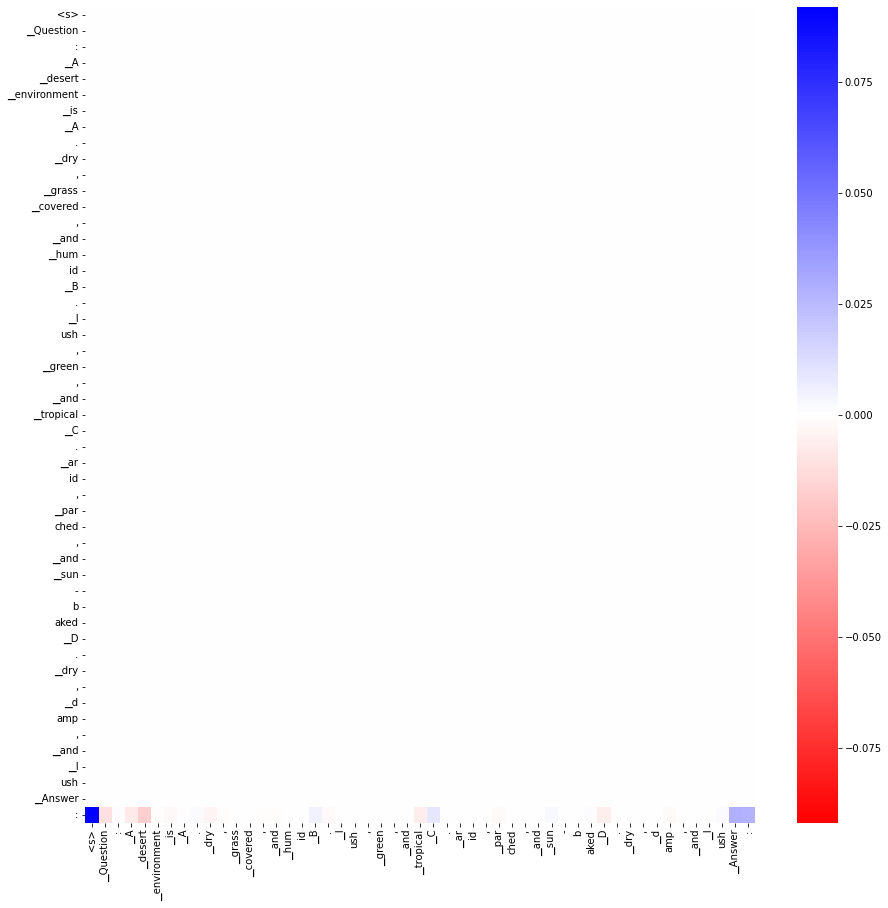

In [50]:
show_question(results_original, 1, -1, True)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


ValueError: can only convert an array of size 1 to a Python scalar

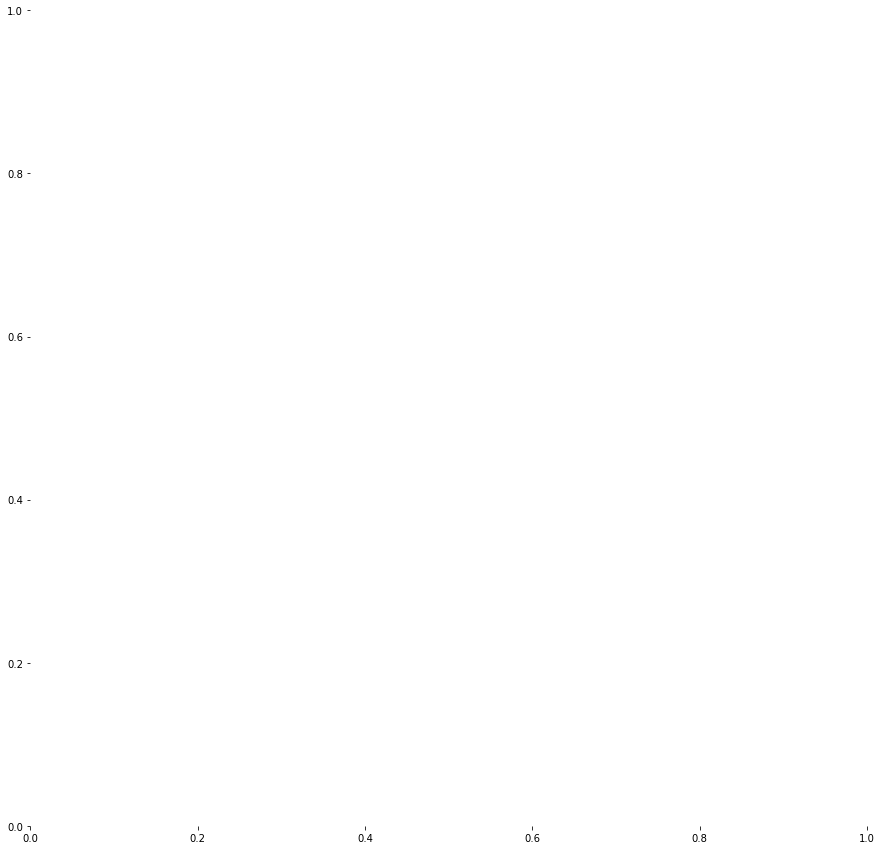

In [110]:
show_question(results_original, 1, -1, True)

In [46]:
[
    (
        i,
        results_original[i]["percentage"].argmax()
        == results_original[i]["correct_choice"],
    )
    for i in range(10)
]
# sum([results_original[i]['percentage'].argmax()==results_original[i]['correct_choice'] for i in range(10)])

[(0, tensor(True)),
 (1, tensor(True)),
 (2, tensor(False)),
 (3, tensor(True)),
 (4, tensor(False)),
 (5, tensor(True)),
 (6, tensor(False)),
 (7, tensor(True)),
 (8, tensor(False)),
 (9, tensor(True))]

In [4]:
results_original[4]["question"]
results_original[4]["percentage"]

tensor([0.1936, 0.2246, 0.0159, 0.4196])

In [5]:
results_neglect = neglect_args.load_result()

In [19]:
def measure_correctness(dataset):
    [
        print(
            i,
            dataset[i]["percentage"].argmax() == dataset[i]["correct_choice"],
        )
        for i in range(len(dataset))
    ]
    return sum(
        [
            dataset[i]["percentage"].argmax() == dataset[i]["correct_choice"]
            for i in range(len(dataset))
        ]
    )

In [20]:
measure_correctness(results_neglect)

0 tensor(True)
1 tensor(False)
2 tensor(False)
3 tensor(False)
4 tensor(False)
5 tensor(False)
6 tensor(False)
7 tensor(True)
8 tensor(True)
9 tensor(True)


tensor(4)

In [8]:
sum(
    [
        results_original[i]["percentage"].argmax()
        == results_original[i]["correct_choice"]
        for i in range(10)
    ]
)

tensor(6)

In [45]:
print(results_original[7]["question"], results_original[7]["percentage"])
print(results_neglect[7]["percentage"])

Question: Which of the following is most likely to make a person shiver?
 A. being in a gym
 B. being in a sauna
 C. being in a fridge
 D. being in a pool
Answer: tensor([0.0068, 0.2684, 0.5174, 0.0321])
tensor([0.0415, 0.3817, 0.1949, 0.0546])


In [4]:
def get_proportion(grads_one_layer, class_poss, final_poss):
    grads_one_layer = grads_one_layer.detach().clone().cpu()
    class_poss = torch.hstack(class_poss).detach().clone().cpu()
    final_poss = final_poss.detach().clone().cpu()
    grads_one_layer = grads_one_layer.numpy()
    np.fill_diagonal(grads_one_layer, 0)
    proportion1 = grads_one_layer[class_poss, :].sum()
    proportion2 = grads_one_layer[final_poss, class_poss].sum()
    proportion3 = grads_one_layer.sum() - proportion1 - proportion2

    N = int(final_poss)
    sum3 = (N + 1) * N / 2 - sum(class_poss) - len(class_poss)
    proportion1 = proportion1 / sum(class_poss)
    proportion2 = proportion2 / len(class_poss)
    proportion3 = proportion3 / sum3
    proportions = np.array([proportion1, proportion2, proportion3])
    return proportions

In [23]:
plot_thu = [
    get_proportion(grads[0][layer], results[0]["class_pos"], results[0]["final_pos"])[1]
    for layer in range(40)
]

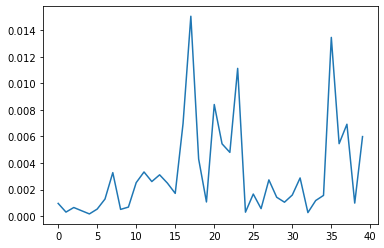

In [25]:
plt.plot(plot_thu)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.05', '0.01', '0.70', '0.15'], correct choice: 2


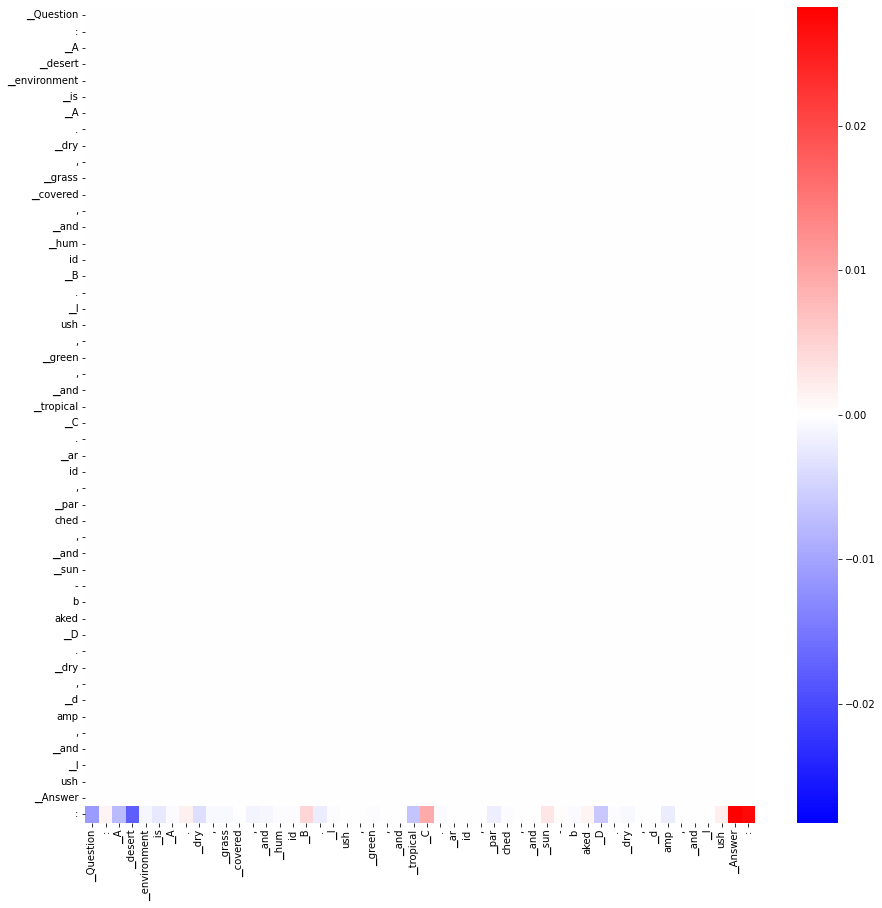

In [126]:
cmap = LinearSegmentedColormap.from_list("", ["red", "white", "blue"])


def get_df(bundle, question_id, layer_id, show_attention=False, start_index=0):
    ques = bundle[question_id]
    viewing = (
        ques["attentions"][layer_id] if show_attention else -ques["grads"][layer_id]
    )
    ss = ques["final_pos"] + 1
    tokens = ques["tokens"][start_index:ss]
    viewing = viewing[start_index:ss, start_index:ss].clone()
    if show_attention:
        viewing[[np.arange(viewing.shape[0])] * 2] = 0
    df_cm = pd.DataFrame(viewing, index=tokens, columns=tokens)
    return df_cm


def show_question(
    bundle, question_id, layer_id, show_info=False, show_attention=False, start_index=0
):
    ques = bundle[question_id]
    if show_info:
        print(ques["question"])
        print(
            f"percent: {[f'{x:.2f}' for x in ques['percentage']]}, correct choice: {ques['correct_choice']}"
        )

    plt.figure(figsize=(15, 15))
    df_cm = get_df(bundle, question_id, layer_id, show_attention, start_index)
    if show_attention:
        sn.heatmap(df_cm, annot=False, cmap="Blues")
    else:
        scale_max = abs(np.max(df_cm.values))
        sn.heatmap(
            df_cm,
            annot=False,
            vmin=-scale_max,
            vmax=scale_max,
            cmap=LinearSegmentedColormap.from_list("", ["blue", "white", "red"]),
        )
    # return viewing


show_question(results_original, 1, -1, True, show_attention=False, start_index=1)

In [67]:
viewing[[np.arange(viewing.shape[0])] * 2] = 0
viewing

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0558, 0.0655, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0426, 0.0171, 0.0071,  ..., 0.0000, 0.0000, 0.0000],
        [0.0284, 0.0151, 0.0057,  ..., 0.0049, 0.0000, 0.0000],
        [0.0305, 0.0106, 0.0081,  ..., 0.0057, 0.0608, 0.0000]],
       dtype=torch.float16)

Question: A desert environment is A. dry, grass covered, and humid B. lush, green, and tropical C. arid, parched, and sun-baked D. dry, damp, and lush Answer:
percent: ['0.18', '0.16', '0.15', '0.14'], correct choice: 2


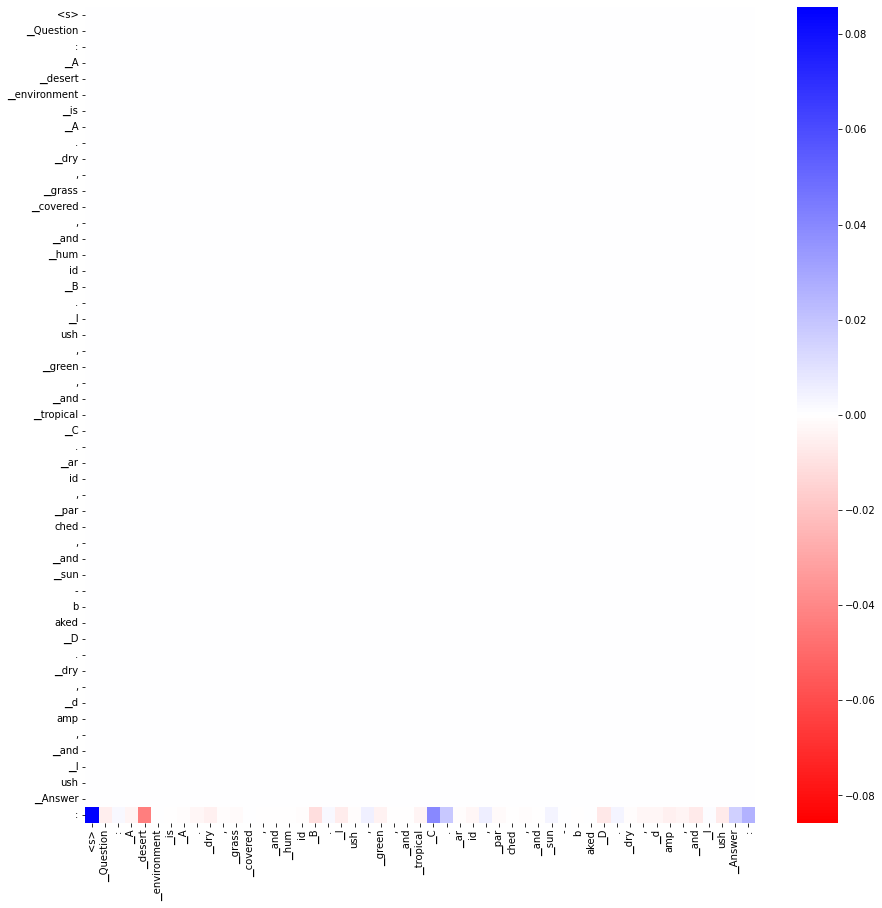

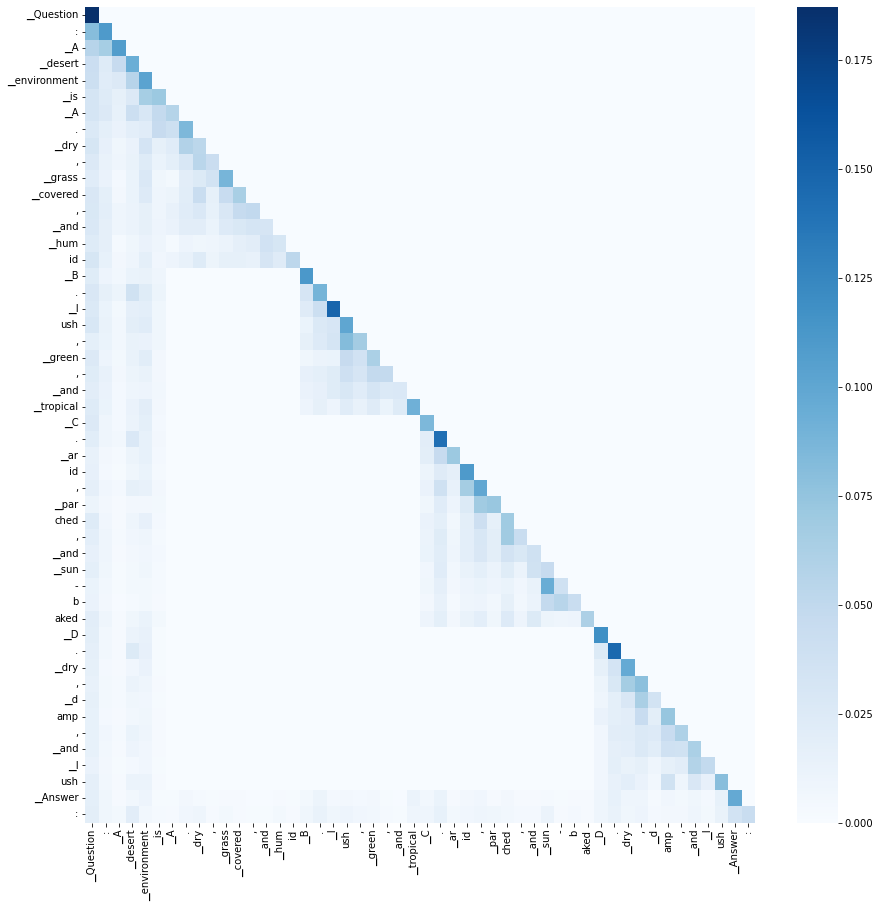

In [24]:
show_question(results_neglect, 1, -1, False, show_attention=True, start_index=1)

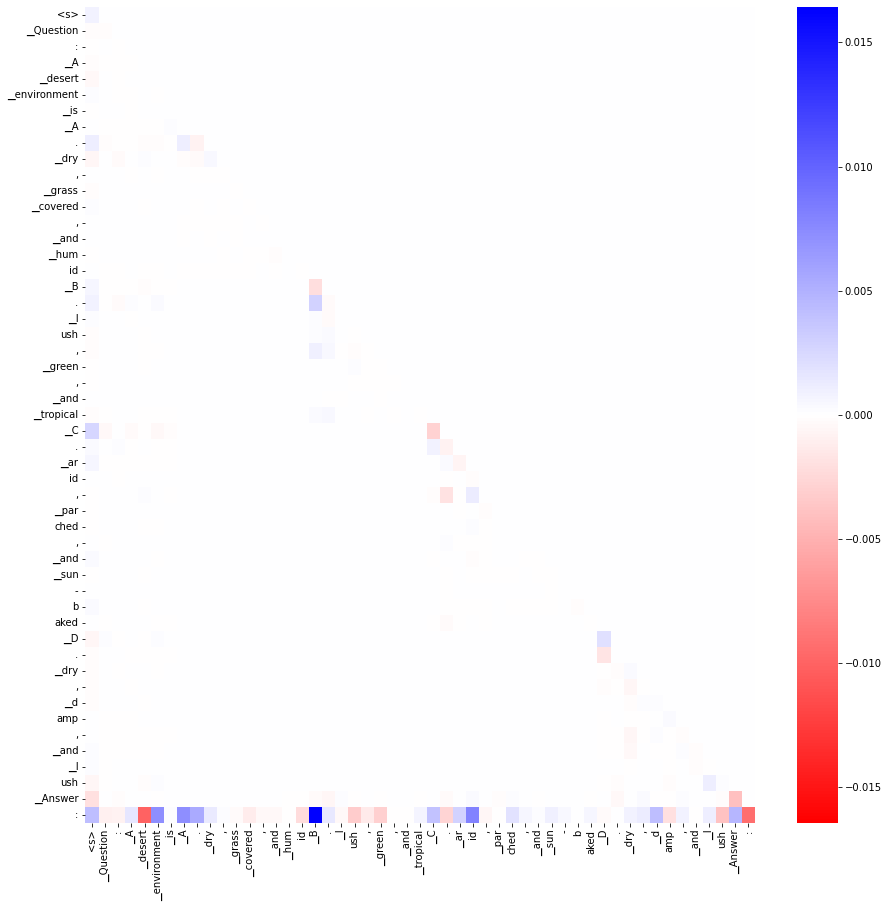

In [94]:
show_question(results_neglect, 1, -6)

In [25]:
results_neglect[7]["class_pos"]

[tensor(18), tensor(26), tensor(34), tensor(42)]

In [34]:
results_neglect[7]["attentions"][0][26].sum()

tensor(1., dtype=torch.float16)

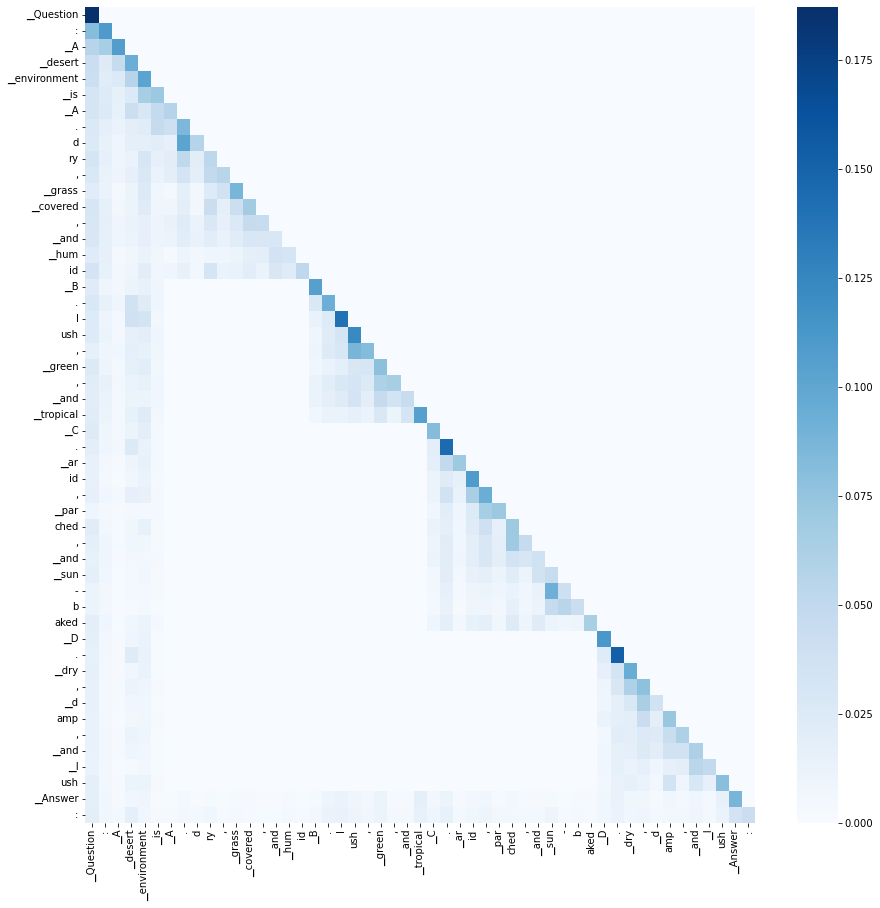

In [86]:
show_question(results_neglect, 1, -1, show_attention=True, start_index=1)

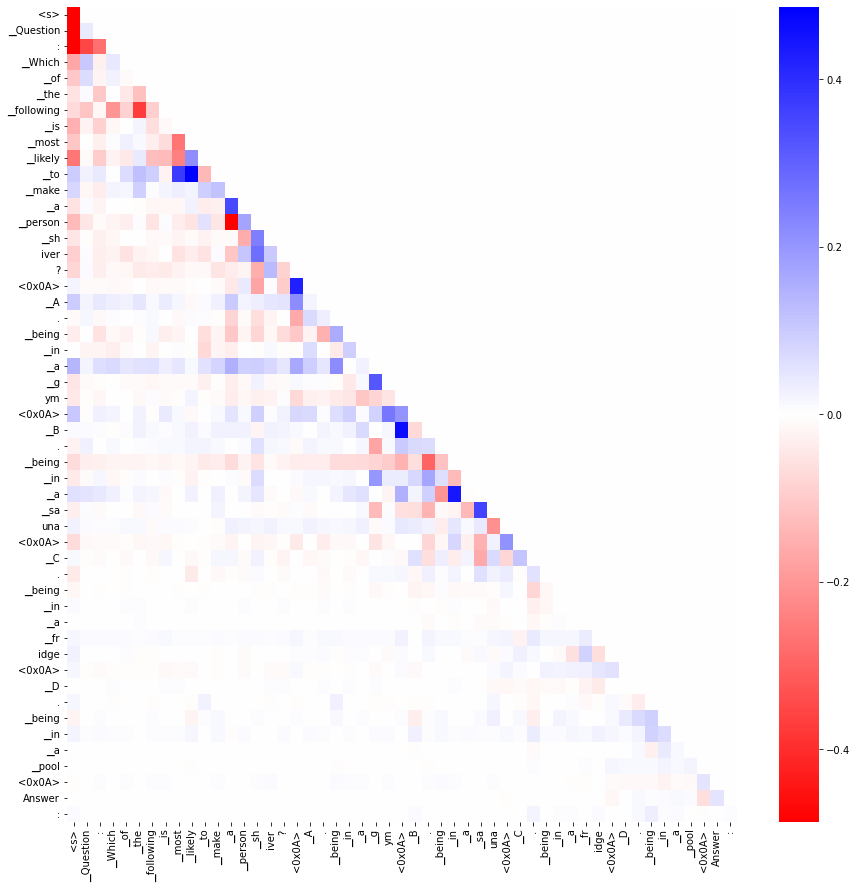

In [52]:
show_question(results_original, 7, 0)

In [52]:
results[layer_id]["class_pos"]

[tensor(15), tensor(20), tensor(26), tensor(31)]

In [53]:
tokens[31]

'▁D'